In [29]:
#!/usr/bin/python3
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

import pandas as pd
import numpy as np
import math
import json
from os import listdir
from os.path import isfile, join
import sys
import glob
import graph_tool.all as gt
from datetime import datetime, date, time
from pyhive import hive
import ast
from queue import LifoQueue, Queue

In [30]:
df = pd.read_csv('/local0/serverless-sim/results/lazy_ser.csv')


df

,benchmark,serialization,finished,execution_time,remote_read,local_read,transfer_time,cpu_time,deserializaion_time,serialization_time,task_time
0,matrixmul_64kx64k_4kx4k,syncwdeser,1227.931739,1227.931739,807051198464,292460429312,857028.036700,43407.508210,1.722713e+03,3798.615106,90187.927650
1,matrixmul_64kx64k_4kx4k,syncnodeser,1226.732460,1226.732460,807051198464,292460429312,855158.348500,43407.508210,1.264486e+03,3798.615106,90155.141710
2,matrixmul_64kx64k_4kx4k,lazy,1125.855576,1125.855576,807051198464,292460429312,902012.811200,43407.508210,1.264486e+03,0.000000,87073.573770
3,matrixmul_10kx10k_1kx1k,syncwdeser,13.766064,13.766064,11584000000,4416000000,7595.203913,105.250180,1.376676e+01,71.348209,772.295953
4,matrixmul_10kx10k_1kx1k,syncnodeser,13.766072,13.766072,11584000000,4416000000,7585.831591,105.250180,9.967134e+00,71.348209,772.865621
5,matrixmul_10kx10k_1kx1k,lazy,12.928800,12.928800,11424000000,4576000000,7218.639517,103.718064,9.829466e+00,0.000000,644.189617
6,tree_reduction_16k,syncwdeser,0.395268,0.395268,173124,285572,0.043662,21.897935,2.732976e-05,0.005238,21.946849
7,tree_reduction_16k,syncnodeser,0.404838,0.404838,173124,285572,0.043713,21.897935,1.031498e-05,0.005238,21.946896
8,tree_reduction_16k,lazy,0.365927,0.365927,173124,285572,0.043538,21.897935,1.031498e-05,0.000000,21.941483
9,tree_reduction_1k,syncwdeser,0.090506,0.090506,10780,17836,0.002728,2.517311,1.704982e-06,0.000327,2.520367


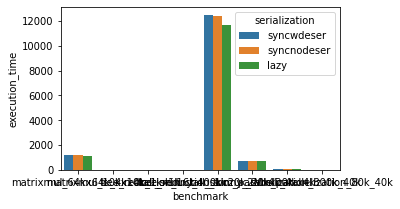

In [31]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(x = 'benchmark', y = 'execution_time', hue='serialization', data = df, ax=ax)

#sns.despine()
#ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

#ax.set_xlim(left=0); 
#ax.set_ylim(bottom=0);

#ax.set_axisbelow(True)
#ax.tick_params(axis='both', which='major')
#ax.yaxis.set_ticks_position('both')
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_title('Lazy serialization'); ax.set_xlabel('Data size'); ax.set_ylabel('Serialization time (sec)'); 

#plt.tight_layout()
#plt.savefig('/local0/serverless-sim/benchmark/fig_serialization.png', format='png', dpi=200)
plt.show()





<AxesSubplot:xlabel='benchmark'>

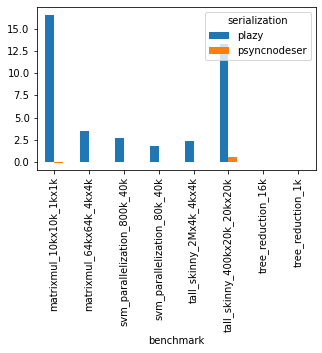

In [34]:
dt = df.pivot(index='benchmark', columns='serialization', values='task_time')

fig, ax = plt.subplots(figsize=(5, 3))


dt['plazy'] = (1 - dt['lazy']/dt['syncwdeser'])*100
dt['psyncnodeser'] = (1 - dt['syncnodeser']/dt['syncwdeser'])*100

dt[['plazy', 'psyncnodeser']].plot.bar(ax=ax)


<AxesSubplot:xlabel='benchmark'>

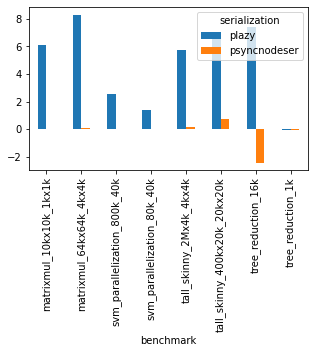

In [35]:
dt = df.pivot(index='benchmark', columns='serialization', values='execution_time')

fig, ax = plt.subplots(figsize=(5, 3))


dt['plazy'] = (1 - dt['lazy']/dt['syncwdeser'])*100
dt['psyncnodeser'] = (1 - dt['syncnodeser']/dt['syncwdeser'])*100

dt[['plazy', 'psyncnodeser']].plot.bar(ax=ax)


In [ ]:
1. what fraction of the transfers was local vs remote 
2. the serialization time vs the entire task time 
3. the amount of memory that I duplicate to the memory. 

lazy = serilaization - scheduler 

try to do time multiplexing  

round robin of colors to nodes 

n workers mapped to A servers 

different consistent hashing and round robin 

try to run sklearn with dask 
